In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, f1_score, mean_squared_error
from sklearn.model_selection import cross_val_score, cross_val_predict, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import LinearSVC, SVC, LinearSVR, SVR
from scipy.stats import reciprocal, uniform

%matplotlib inline

# Exercise 1

What is the fundamental idea behind SVMs?

The idea is to get the widest possible street between classes.

# Exercise 2

What is a support vector?

They are the instances / samples that define the edge of that wide street. They support the street so when new a new instance arrives, unless it crosses the decision boundries, it won't effect the classifier.

# Exercise 3

Why is it important to scale the inputs when using SVMs?

SVMs are sensitive to feature range differences. Having features on different ranges ruins the slop of the hyperplane that is being made and makes it harder to configure and modify to get the best model.

# Exercise 4

Can an SVM classifier output a confidence score when it classifies an instance? What about a probability?

Out of the box, no. However, one can easily set a probabilty function by taking the distance the instance has from the main decision boundry into a sigmoid function. 

# Exercise 5

Should you use the primal or the dual form of the SVM problem to train a model on a training set with millions of instances and hundreds of features?

So if the number of instances is less than the number of features, dual would be faster to compute. So in this instance, one would prefer the primal solution. However, given that primal is not able to kernelize. and given that we might want to polynomialize the features, I would lean toward dual. Dual allows for kernalization, which makes large degrees of polynomials easier to computer.

# Exercise 6

Say you trained an SVC with an RBF kernel. It seems to underfit the training set: should you increase or decrease gamma? What about C?

Increase both gamma and C.

# Exercise 7

How should you set the QP parameters (**H**, **f**, **A**, and **b**) to solve the soft margin linear classifier problem using an off the shelf QP solver?

Assume we have H\`, f\`, A\`, and b\`, which are the parameters you put in the QP for a hard classification. Since we are adding m more parameters to the p vector we have to add a lot of rows and columns to accept it. H will be like H\`, but will have m more rows and columns filled with zero. f with be like f\`, but will have an additional m elements with them being filled with the variable, C. b will be like b\`, but will have an additional m elements filled with 0. and A will be like A\`, but will have an mXm identity matrix to the right of it, an mXm negative identity matrix underneath that, and all zeros beneath the original A\` matrix. So you will have a n+m+1X2m matrix. 

# Exercise 8

Train a `LinearSVC` on a linearly seperable dataset. The train an SVC and a SGDClassifier on the same dataset. See if you can get them to produce roughly the same model.

In [52]:
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
    
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

In [53]:
X_blobs, y_blobs = datasets.make_blobs(n_samples=100, centers=2, cluster_std=1.25)
# plot_dataset(X_blobs, y_blobs, [-15, 15, -15, 15])
# plt.show()

In [54]:
lin_svc = Pipeline((
    ("scaler", StandardScaler()),
    ("lin_svc", LinearSVC(C=5, loss="hinge"))
)) 
unused = lin_svc.fit(X_blobs, y_blobs)

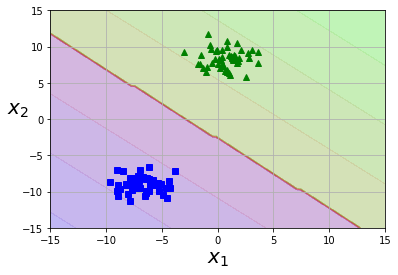

In [55]:
plot_predictions(lin_svc, [-15, 15, -15, 15])
plot_dataset(X_blobs, y_blobs, [-15, 15, -15, 15])
plt.show()

In [60]:
poly_kernel_svm_clf = Pipeline((
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="linear", C=5))
))
unused = poly_kernel_svm_clf.fit(X_blobs, y_blobs)

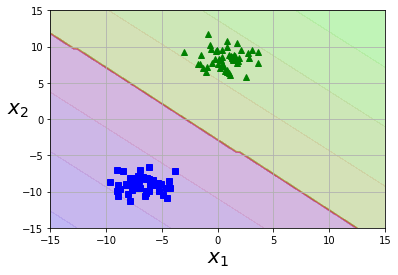

In [61]:
plot_predictions(poly_kernel_svm_clf, [-15, 15, -15, 15])
plot_dataset(X_blobs, y_blobs, [-15, 15, -15, 15])
plt.show()

In [62]:
sgd_clf = Pipeline((
    ("scaler", StandardScaler()),
    ("sgd_clf", SGDClassifier())
))
unused = sgd_clf.fit(X_blobs, y_blobs)

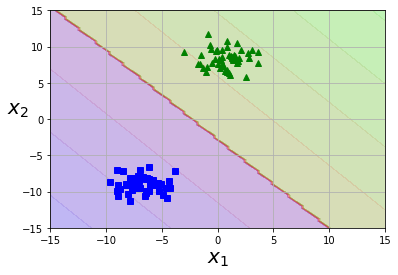

In [63]:
plot_predictions(sgd_clf, [-15, 15, -15, 15])
plot_dataset(X_blobs, y_blobs, [-15, 15, -15, 15])
plt.show()

# Exercise 9

Train an SVM classifier on the MNIST dataset. Since SVM classifiers are binary classifiers, you will need to use one-versus-all to classify all 10 digits. You may want to tune the hyperparameters using small validation sets to speed up the process. What accuracy can you reach?

In [77]:
mnist = datasets.fetch_mldata("MNIST original")
X,y = mnist["data"], mnist["target"]
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
shuffle_index =a np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]
shuffle_index = np.random.permutation(10000)
X_test, y_test = X_test[shuffle_index], y_test[shuffle_index]
print "Data in memory"

 Data in memory


In [132]:
train_s = 5000
test_s = 100

In [135]:
mnist_lin_svc = Pipeline((
    ("scaler", StandardScaler()),
    ("lin_svc", LinearSVC(C=0.005, loss="hinge"))
))
unused = mnist_lin_svc.fit(X_train[:train_s], y_train[:train_s])
y_train_svc_pred = cross_val_predict(mnist_lin_svc, X_train[:train_s], y_train[:train_s], cv=5)
print "Train Accuracy: ", cross_val_score(mnist_lin_svc, X_train[:train_s], y_train[:train_s], cv=5, scoring="accuracy").mean()
print "Train F1: ", f1_score(y_train[:train_s], y_train_svc_pred, average="macro")
y_test_svc_pred = cross_val_predict(mnist_lin_svc, X_test[:test_s], y_test[:test_s], cv=5)
print "Test Accuracy: ", cross_val_score(mnist_lin_svc, X_test[:test_s], y_test[:test_s], cv=5, scoring="accuracy").mean()
print "Test F1: ", f1_score(y_test[:test_s], y_test_svc_pred, average="macro")

Train Accuracy:  0.861801848116
Train F1:  0.860259631649
Test Accuracy:  0.748383838384
Test F1:  0.736936800057


In [138]:
mnist_poly_svc = Pipeline((
    ("scaler", StandardScaler()),
    ("poly_svc", SVC(kernel="poly", degree=2, C=0.1))
))
unused = mnist_poly_svc.fit(X_train[:train_s], y_train[:train_s])
y_train_svc_pred = cross_val_predict(mnist_poly_svc, X_train[:train_s], y_train[:train_s], cv=5)
print "Train Accuracy: ", cross_val_score(mnist_poly_svc, X_train[:train_s], y_train[:train_s], cv=5, scoring="accuracy").mean()
print "Train F1: ", f1_score(y_train[:train_s], y_train_svc_pred, average="macro")
y_test_svc_pred = cross_val_predict(mnist_poly_svc, X_test[:test_s], y_test[:test_s], cv=5)
print "Test Accuracy: ", cross_val_score(mnist_poly_svc, X_test[:test_s], y_test[:test_s], cv=5, scoring="accuracy").mean()
print "Test F1: ", f1_score(y_test[:test_s], y_test_svc_pred, average="macro")

Train Accuracy:  0.588971212264
Train F1:  0.590254533208
Test Accuracy:  0.181439393939
Test F1:  0.126239316239


In [131]:
mnist_rbf_svc = Pipeline((
    ("scaler", StandardScaler()),
    ("rbf_svc", SVC(kernel="rbf", gamma=1e-4, C=1))
))
unused = mnist_rbf_svc.fit(X_train[:train_s], y_train[:train_s])
y_train_svc_pred = cross_val_predict(mnist_rbf_svc, X_train[:train_s], y_train[:train_s], cv=5)
print "Train Accuracy: ", cross_val_score(mnist_rbf_svc, X_train[:train_s], y_train[:train_s], cv=5, scoring="accuracy").mean()
print "Train F1: ", f1_score(y_train[:train_s], y_train_svc_pred, average="macro")
y_test_svc_pred = cross_val_predict(mnist_rbf_svc, X_test[:test_s], y_test[:test_s], cv=5)
print "Test Accuracy: ", cross_val_score(mnist_rbf_svc, X_test[:test_s], y_test[:test_s], cv=5, scoring="accuracy").mean()
print "Test F1: ", f1_score(y_test[:test_s], y_test_svc_pred, average="macro")

Train Accuracy:  0.74182597264
Train F1:  0.733523190843
Test Accuracy:  0.247171717172
Test F1:  0.106628481581


# Best Model was LinearSVC

In [139]:
unused = mnist_lin_svc.fit(X_train, y_train)
y_train_svc_pred = cross_val_predict(mnist_lin_svc, X_train, y_train, cv=5)
print "Train Accuracy: ", cross_val_score(mnist_lin_svc, X_train, y_train, cv=5, scoring="accuracy").mean()
print "Train F1: ", f1_score(y_train, y_train_svc_pred, average="macro")
y_test_svc_pred = cross_val_predict(mnist_lin_svc, X_test, y_test, cv=5)
print "Test Accuracy: ", cross_val_score(mnist_lin_svc, X_test, y_test, cv=5, scoring="accuracy").mean()
print "Test F1: ", f1_score(y_test, y_test_svc_pred, average="macro")

Train Accuracy:  0.904999712352
Train F1:  0.903643962404
Test Accuracy:  0.889102137881
Test F1:  0.887302219332


# Exercise 10

Train an SVM regressor on the California housing dataset.

In [27]:
housing = datasets.fetch_california_housing()
X = housing["data"]
y = housing["target"]

In [28]:
X_t, X_v, y_t, y_v = train_test_split(X, y, test_size=0.2)

In [29]:
scaler = StandardScaler()
X_t_scl = scaler.fit_transform(X_t)
X_v_scl = scaler.fit_transform(X_v)

In [30]:
lin_svr = LinearSVR()
lin_svr.fit(X_t_scl, y_t)

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)

In [31]:
y_pred = lin_svr.predict(X_t_scl)
mse = mean_squared_error(y_t, y_pred)
np.sqrt(mse)

1.3741918713632491

In [32]:
param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(SVR(), param_distributions, n_iter=10, verbose=2, random_state=42)
rnd_search_cv.fit(X_t_scl, y_t)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=4.74540118847, gamma=0.0796945481864 ..........................
[CV] ........... C=4.74540118847, gamma=0.0796945481864, total=   6.8s
[CV] C=4.74540118847, gamma=0.0796945481864 ..........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.5s remaining:    0.0s


[CV] ........... C=4.74540118847, gamma=0.0796945481864, total=   6.8s
[CV] C=4.74540118847, gamma=0.0796945481864 ..........................
[CV] ........... C=4.74540118847, gamma=0.0796945481864, total=   7.1s
[CV] C=8.31993941811, gamma=0.0157513204998 ..........................
[CV] ........... C=8.31993941811, gamma=0.0157513204998, total=   9.9s
[CV] C=8.31993941811, gamma=0.0157513204998 ..........................
[CV] ........... C=8.31993941811, gamma=0.0157513204998, total=   9.0s
[CV] C=8.31993941811, gamma=0.0157513204998 ..........................
[CV] ........... C=8.31993941811, gamma=0.0157513204998, total=   8.6s
[CV] C=2.56018640442, gamma=0.00205111041884 .........................
[CV] .......... C=2.56018640442, gamma=0.00205111041884, total=   6.1s
[CV] C=2.56018640442, gamma=0.00205111041884 .........................
[CV] .......... C=2.56018640442, gamma=0.00205111041884, total=   7.0s
[CV] C=2.56018640442, gamma=0.00205111041884 .........................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  4.9min finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f56796ff310>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5678d395d0>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [33]:
be = rnd_search_cv.best_estimator_

In [34]:
y_pred = be.predict(X_t_scl)
np.sqrt(mean_squared_error(y_t, y_pred))

0.57395623759134773

In [35]:
y_pred = be.predict(X_v_scl)
np.sqrt(mean_squared_error(y_v, y_pred))

0.58929796231551013